In [1]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data_cleaning import clean_dataset
from data_utils import load_movie_data_limited, load_and_preprocess_data, load_movie_data, cluster_genres, \
    _load_all_data_with_embeddings, expand_by_genre, map_genre_ids_to_strings, keep_top_n_genres
from analysis.stats_data import plot_genre_drift, prepare_heatmap_data, plot_clustermap, \
    plot_standard_heatmap, calculate_genre_convergence, plot_pairwise_convergence, plot_mean_convergence, \
    calculate_drift_metrics
from chunking.calculations import compute_cosine_distance, calculate_drift_vector

BASE_DIR = Path.cwd().parent.parent
SRC_DIR = BASE_DIR / 'src'
sys.path.insert(0, str(SRC_DIR))

DATA_DIR = str(BASE_DIR / "data")
GENRE_MAP_JSON_PATH = str(SRC_DIR / "cluster_to_genre_mapping_01122025.json")
OUTPUT_DIR = None
N_MOVIES_PER_YEAR = None
RANDOM_SEED = 42
START_YEAR = 1960
TOP_X_GENRES = 5
BIN_SIZE = 10
TOP_K_GENRES = 5


# Load clean data with new genres
df_movies = _load_all_data_with_embeddings(DATA_DIR)
print(df_movies.shape)

# Clean using Bartol's function
df_movies = await clean_dataset(df_movies, new_event_loop=False)
print(df_movies.shape)

# Expand the movies: if it has 2 genres then repeat it 2 times one per each genre
df_movies = expand_by_genre(df_movies)
print(df_movies.shape)

# Map so instead of Genre identifiers we have the genre name
df_movies = map_genre_ids_to_strings(df_movies, GENRE_MAP_JSON_PATH)
print(df_movies.shape)

# Keep top k genres because 20 genre plots are ugly
df_movies = keep_top_n_genres(df_movies, TOP_K_GENRES)
print(df_movies.shape)


/home/martin/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(87718, 33)
Original dataset size: 87718
After filtering movies without plot: 87718
After filtering non-movies: 86941
After removing single-occurrence genres from genre column: 86941
After filtering movies with plot length > 14000 chars: 86922
(86922, 34)
(128516, 34)
(115974, 34)
(25932, 34)


# Genre drift Metrics: Velocity, Acceleration and Cumulative Change

We group movies by year and genre, to analyze how each group changes it's average embedding cosine distance.

For each genre, we calculate how much the genre has changed each year compared to the previous year (drift distance) and the cumulative change over time (cumulative change).

We also calculate the acceleration, the change of the velocity over the year.





Drift DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               364 non-null    int64  
 1   new_genre          364 non-null    object 
 2   avg_embedding      364 non-null    object 
 3   drift_distance     364 non-null    float64
 4   acceleration       364 non-null    float64
 5   cumulative_change  364 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 19.9+ KB
None


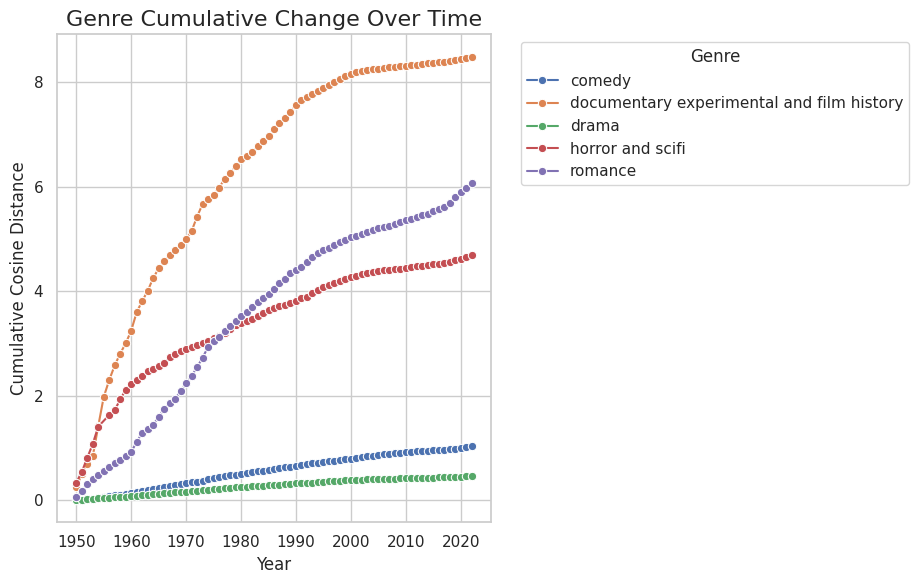

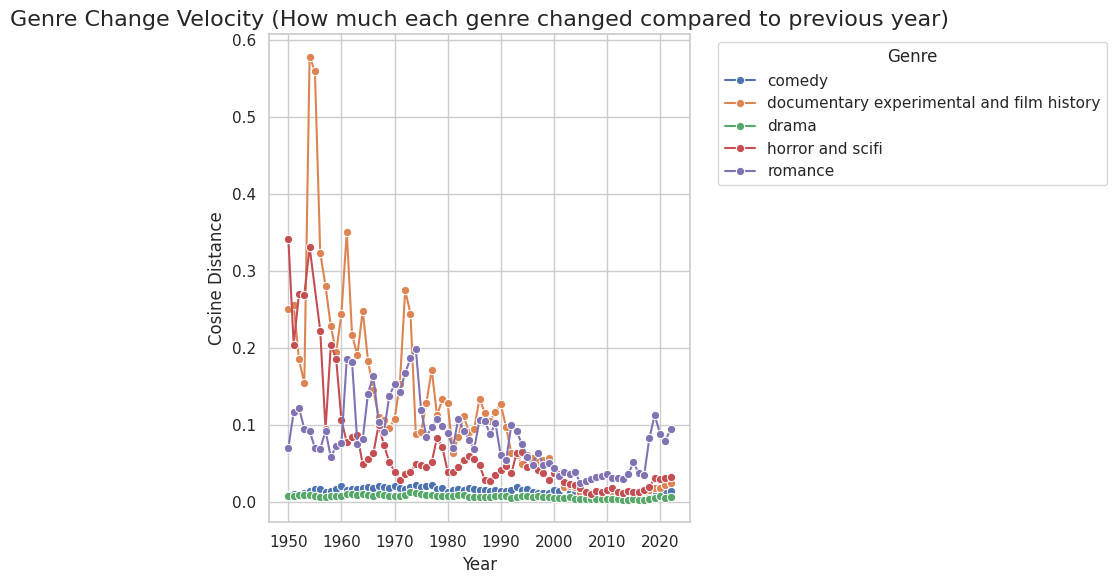

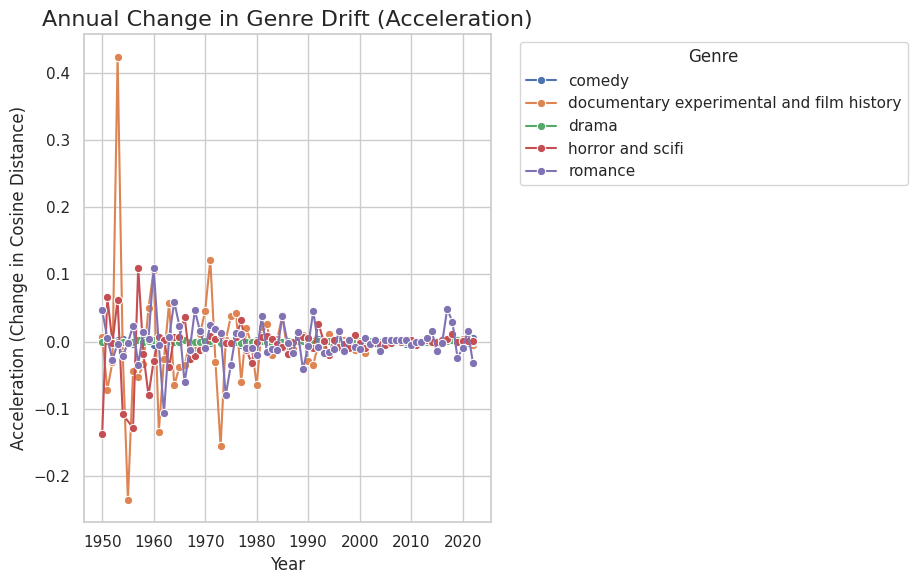

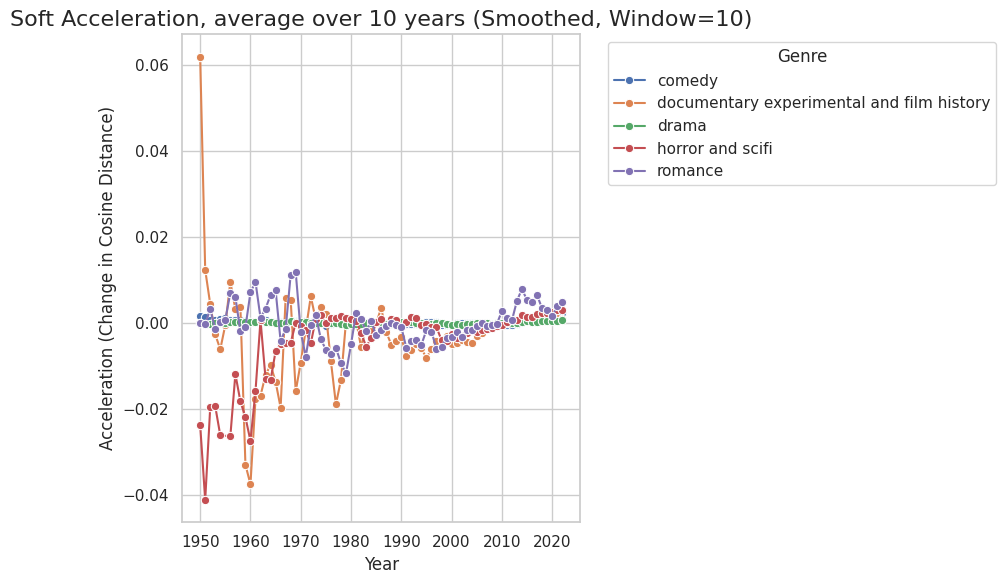

In [2]:
drift_df = calculate_drift_metrics(df_movies)

print("\nDrift DataFrame Info:")
print(drift_df.info())

plot_genre_drift(
    df=drift_df,
    y_column='cumulative_change',
    title='Genre Cumulative Change Over Time',
    y_label='Cumulative Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='drift_distance',
    title='Genre Change Velocity (How much each genre changed compared to previous year)',
    y_label='Cosine Distance'
)

plot_genre_drift(
    df=drift_df,
    y_column='acceleration',
    title='Annual Change in Genre Drift (Acceleration)',
    y_label='Acceleration (Change in Cosine Distance)',
    softness_window=None
)

soft_years = 10
plot_genre_drift(
    df=drift_df,
    y_column='acceleration',
    title=f'Soft Acceleration, average over {soft_years} years',
    y_label='Acceleration (Change in Cosine Distance)',
    softness_window=10
)


# Heatmaps of genre drift

For each genre, we group the data into time bins (e.g., 5 or 10 years) and calculate the mean embedding vector for each bin. The drift distance (velocity) is then calculated as the Cosine Distance between the mean embedding vector of one time bin and the next. This distance measures how much the overall genre meaning has shifted or evolved between the two periods.

We plot heatmaps and to visualize the relationships between different time periods within each genre. Y axis is each embedding dimension, X axis is change between two time intervals. The intensity of the color represents the magnitude of the drift (Cosine Distance), showing if the genre is rapidly changing (high distance) or stable (low distance) over time. The color of the color represents the direction of the change, orange if positive, blue if negative. If two time consecutive time periods have the same color, it means that the genre is evolving in the same direction. If it has different colors, the direction has changed between those two time periods.

There are two plots per genre. The first one has the Y axis ordered according to the vector embeddings, the second one is clustered by directions which evolve in similar directions (positive / negative) so it can be interpreted easier.


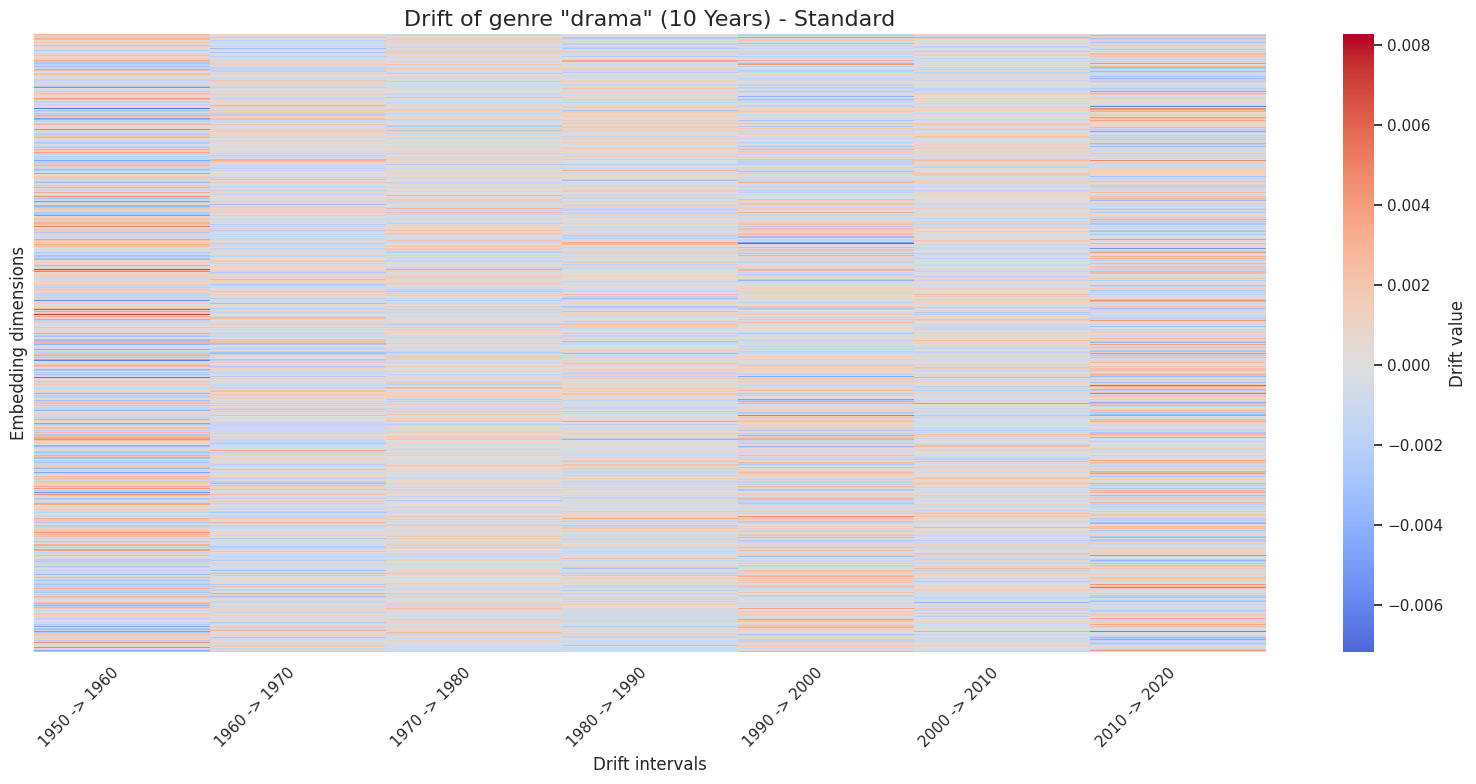

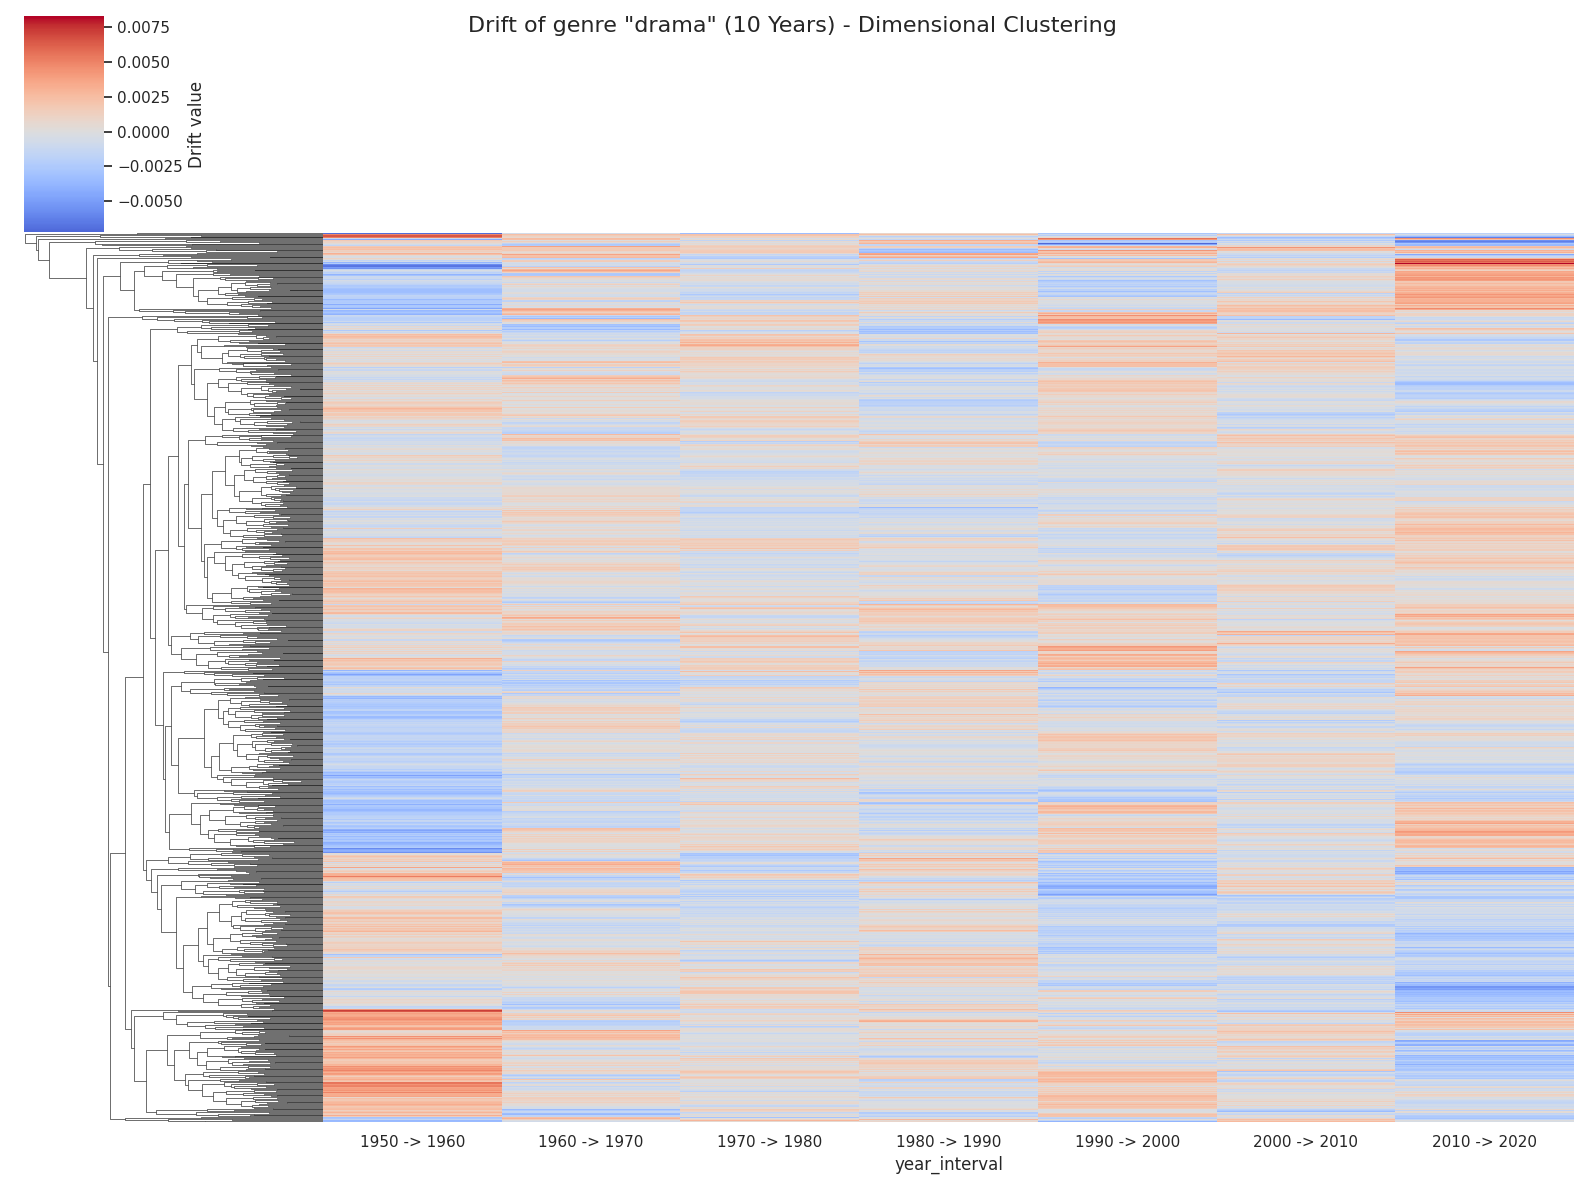

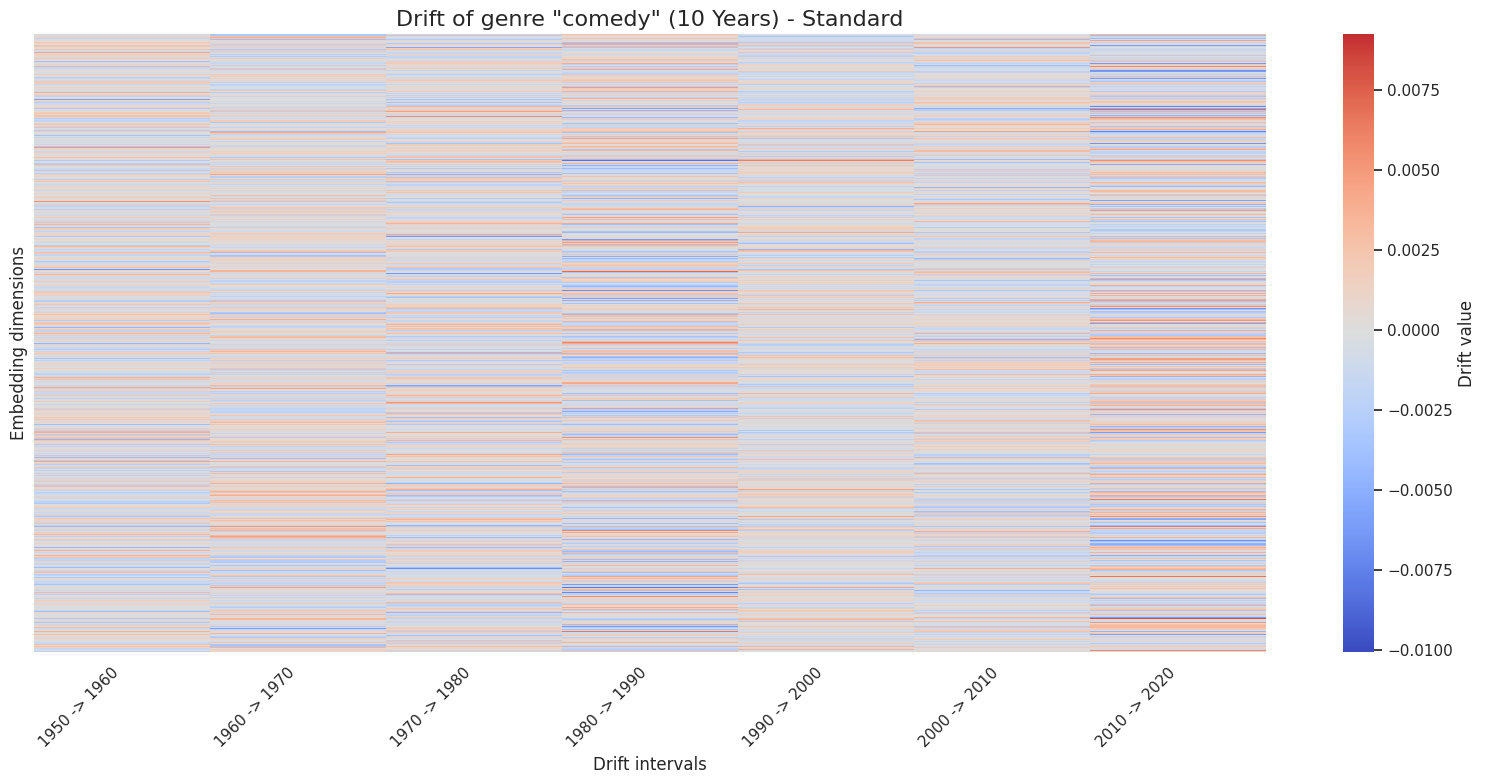

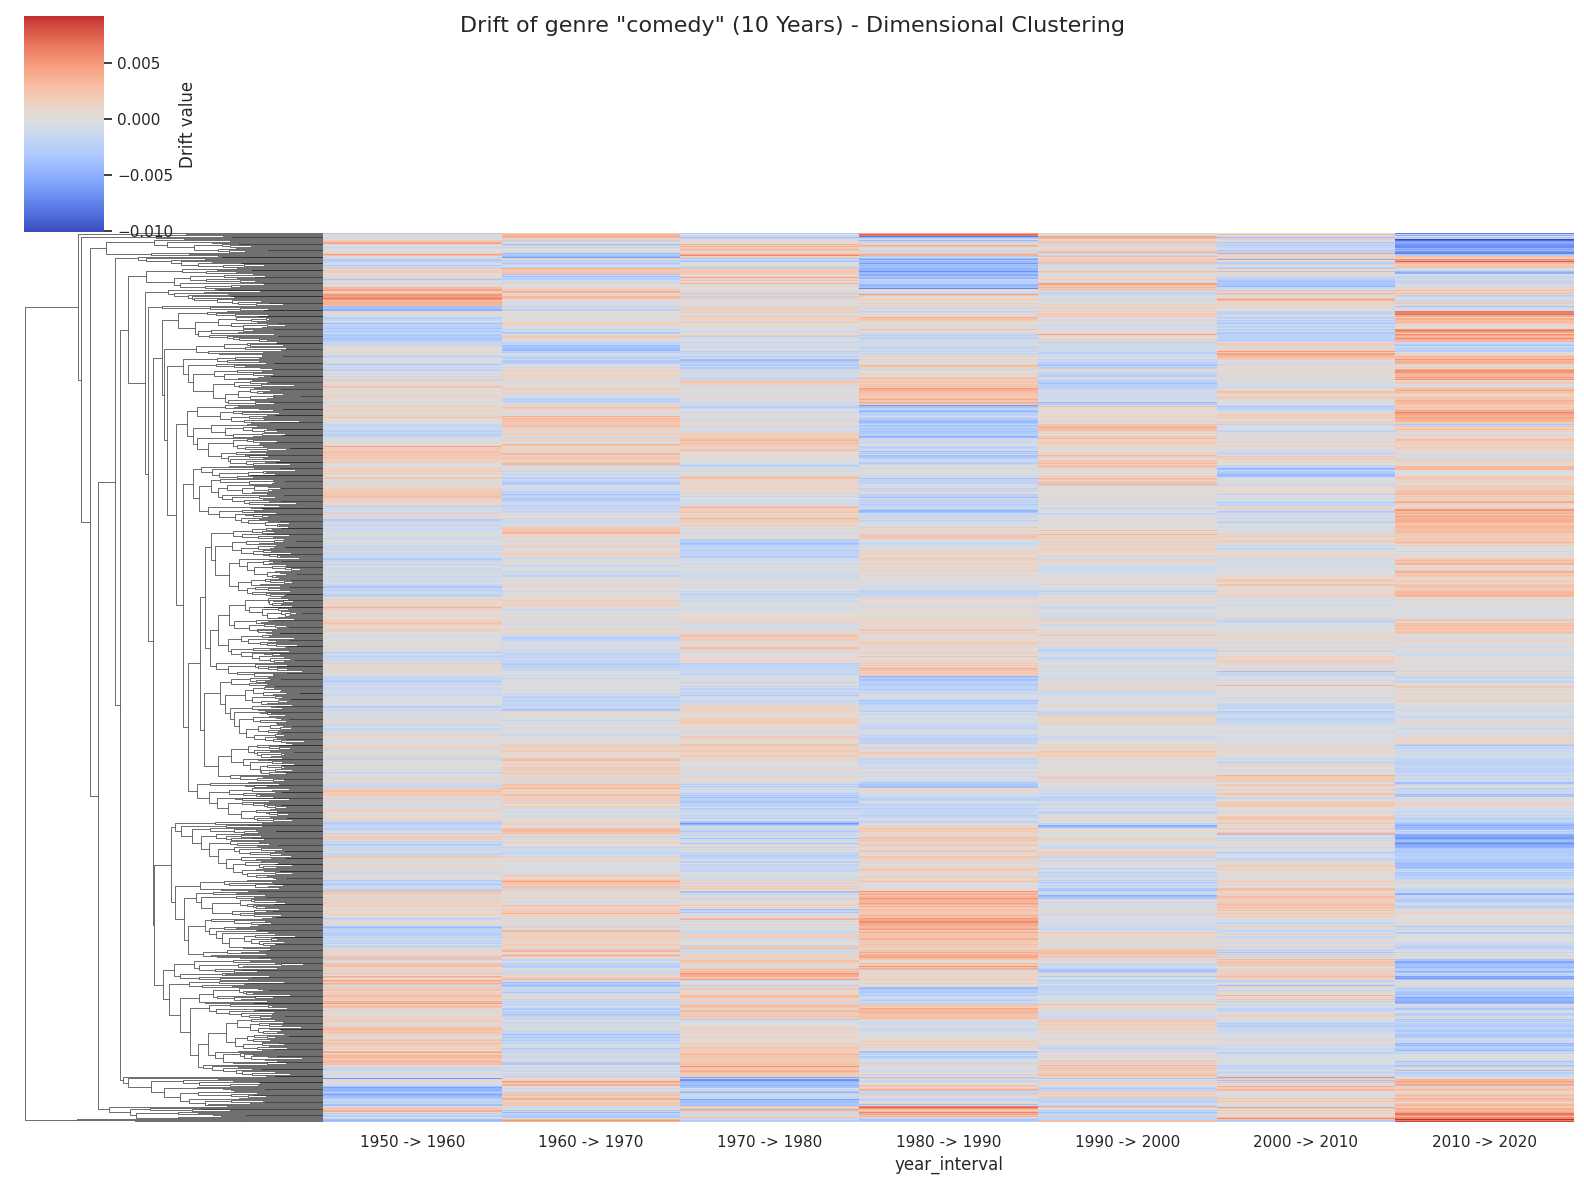

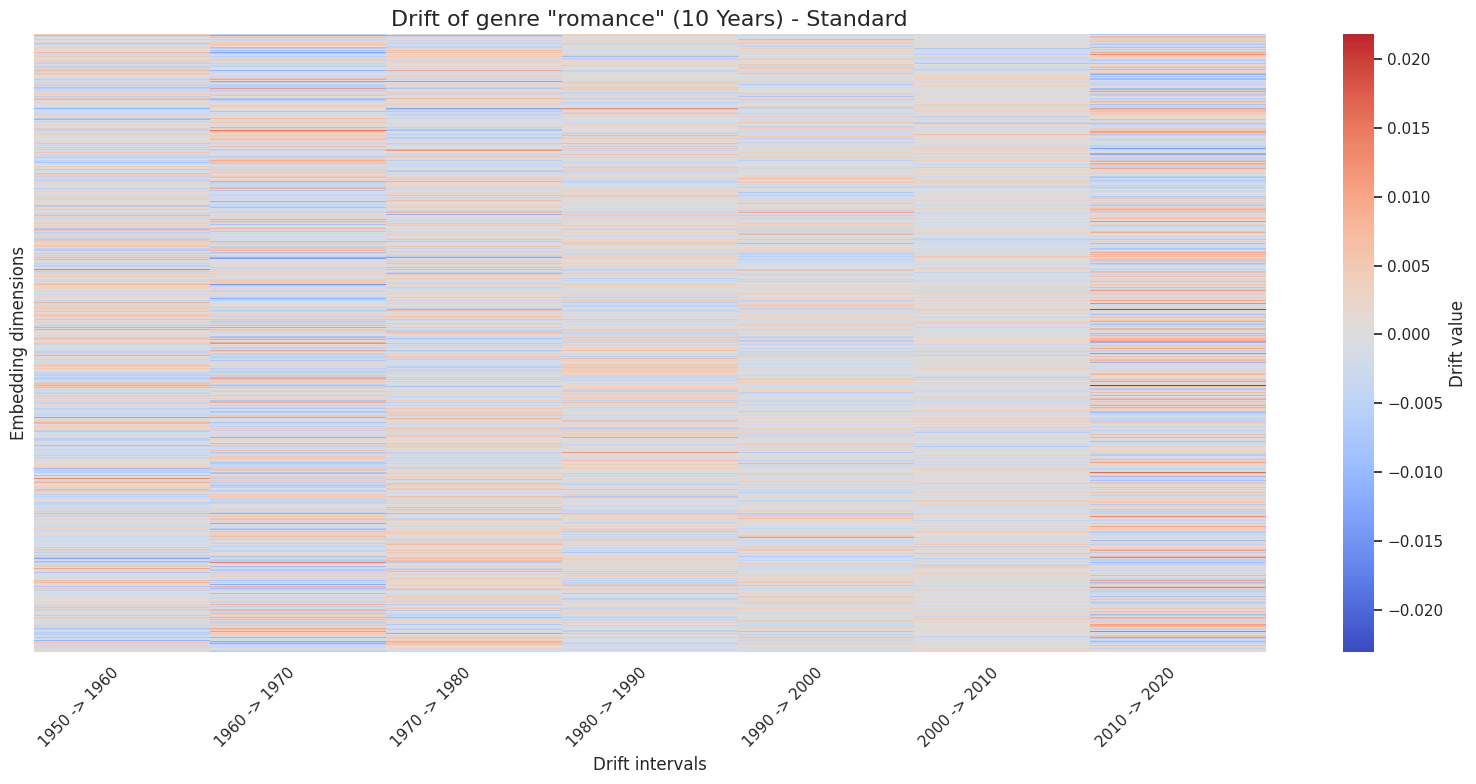

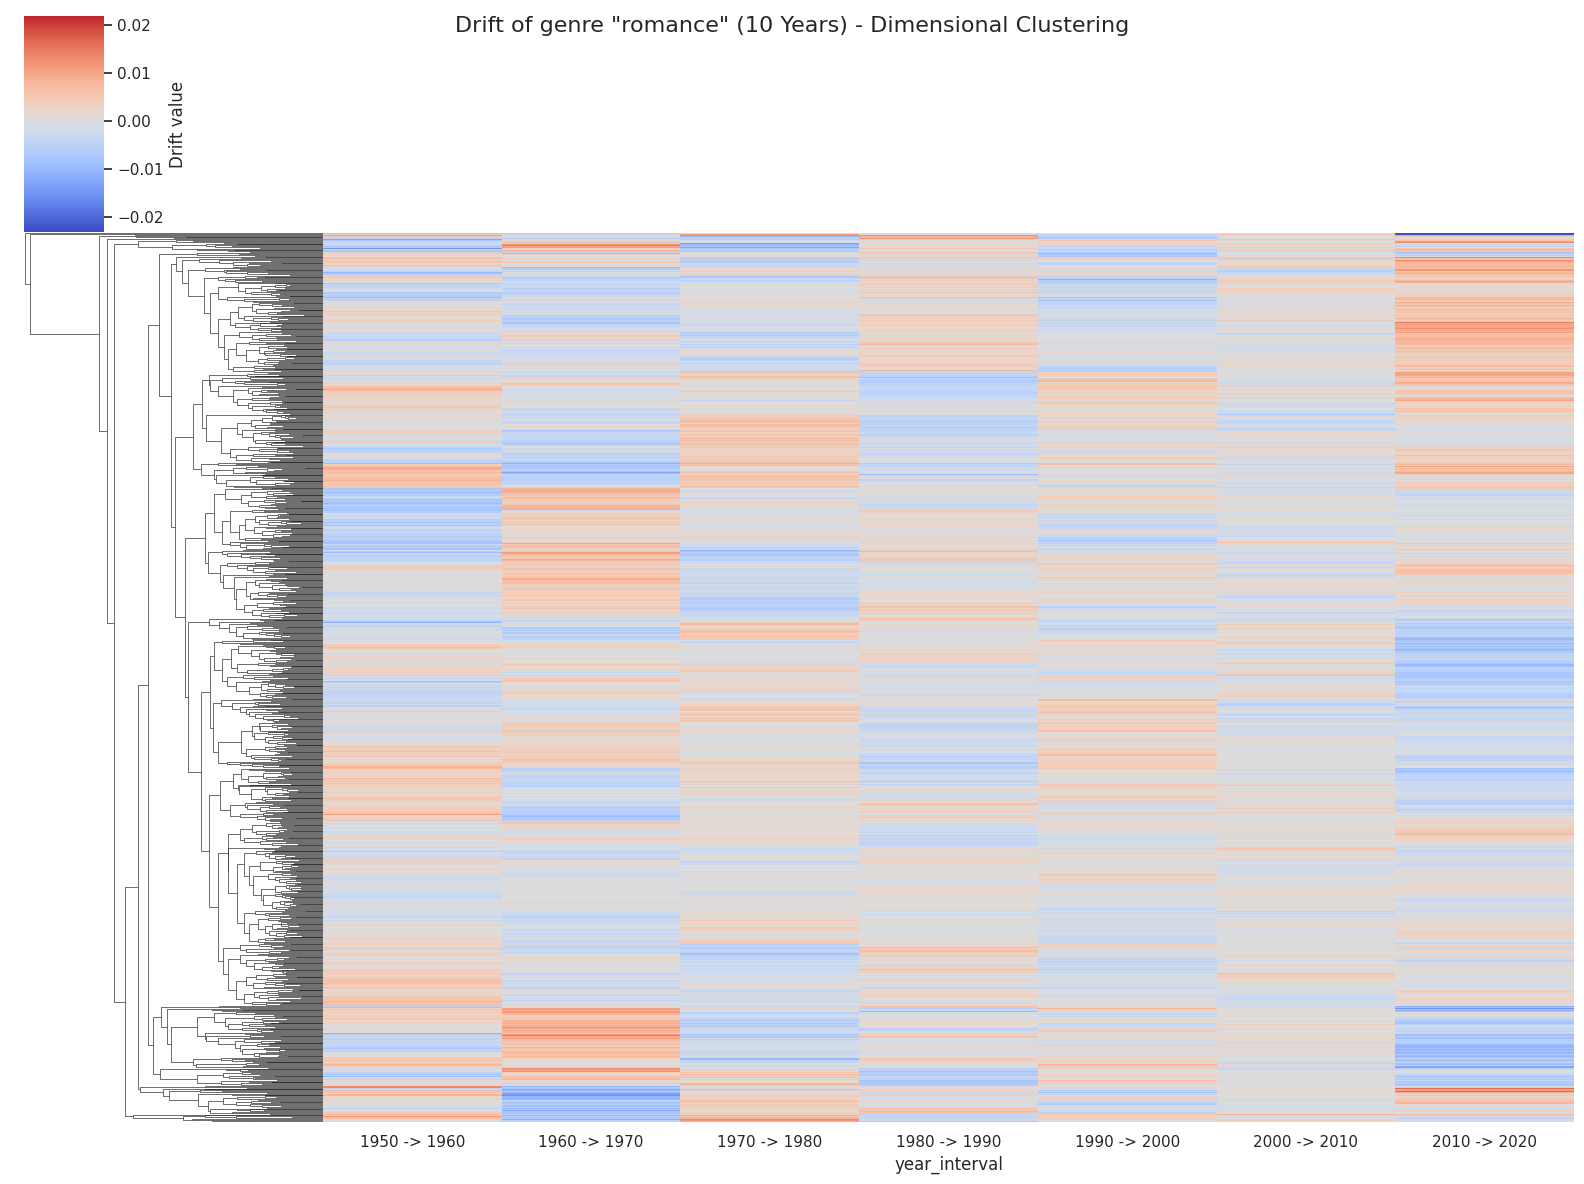

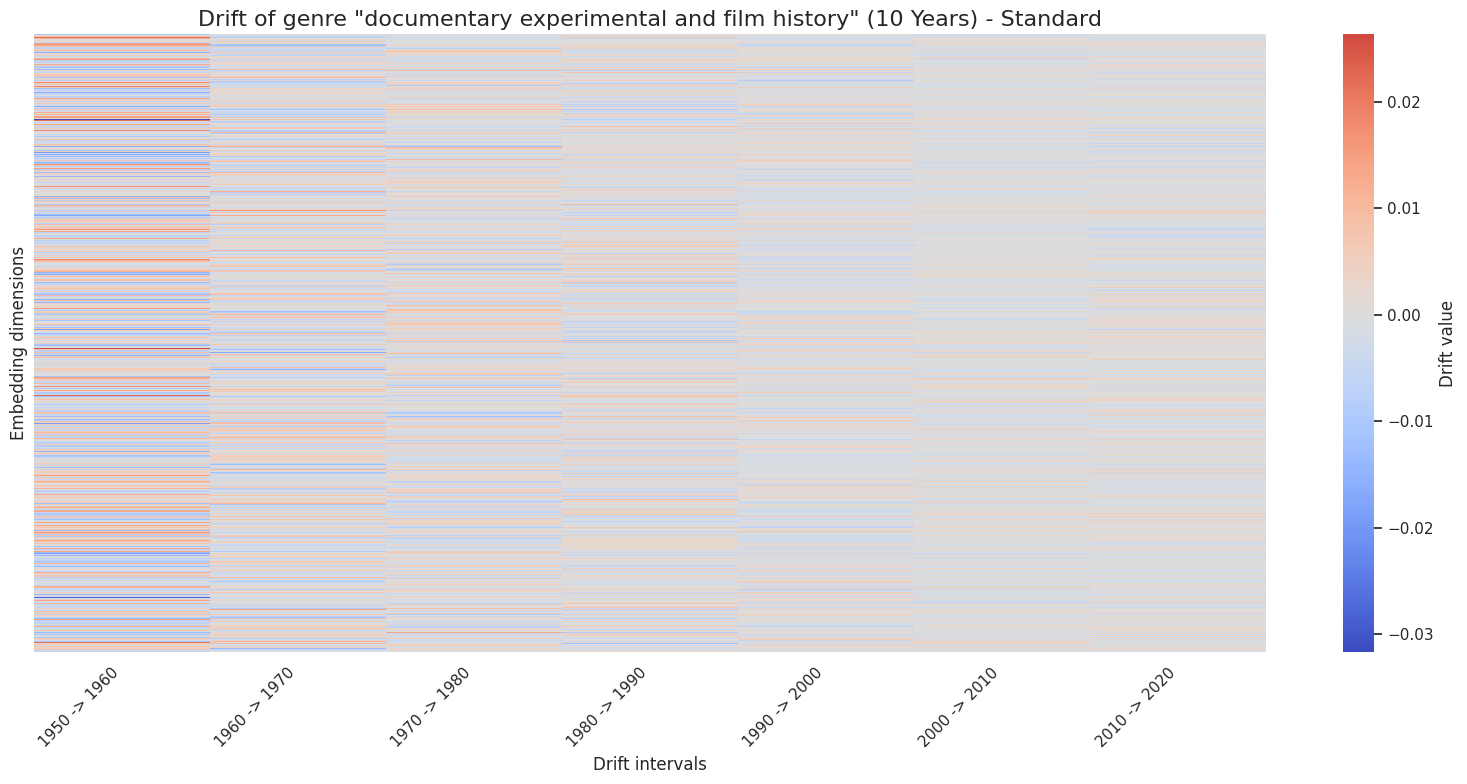

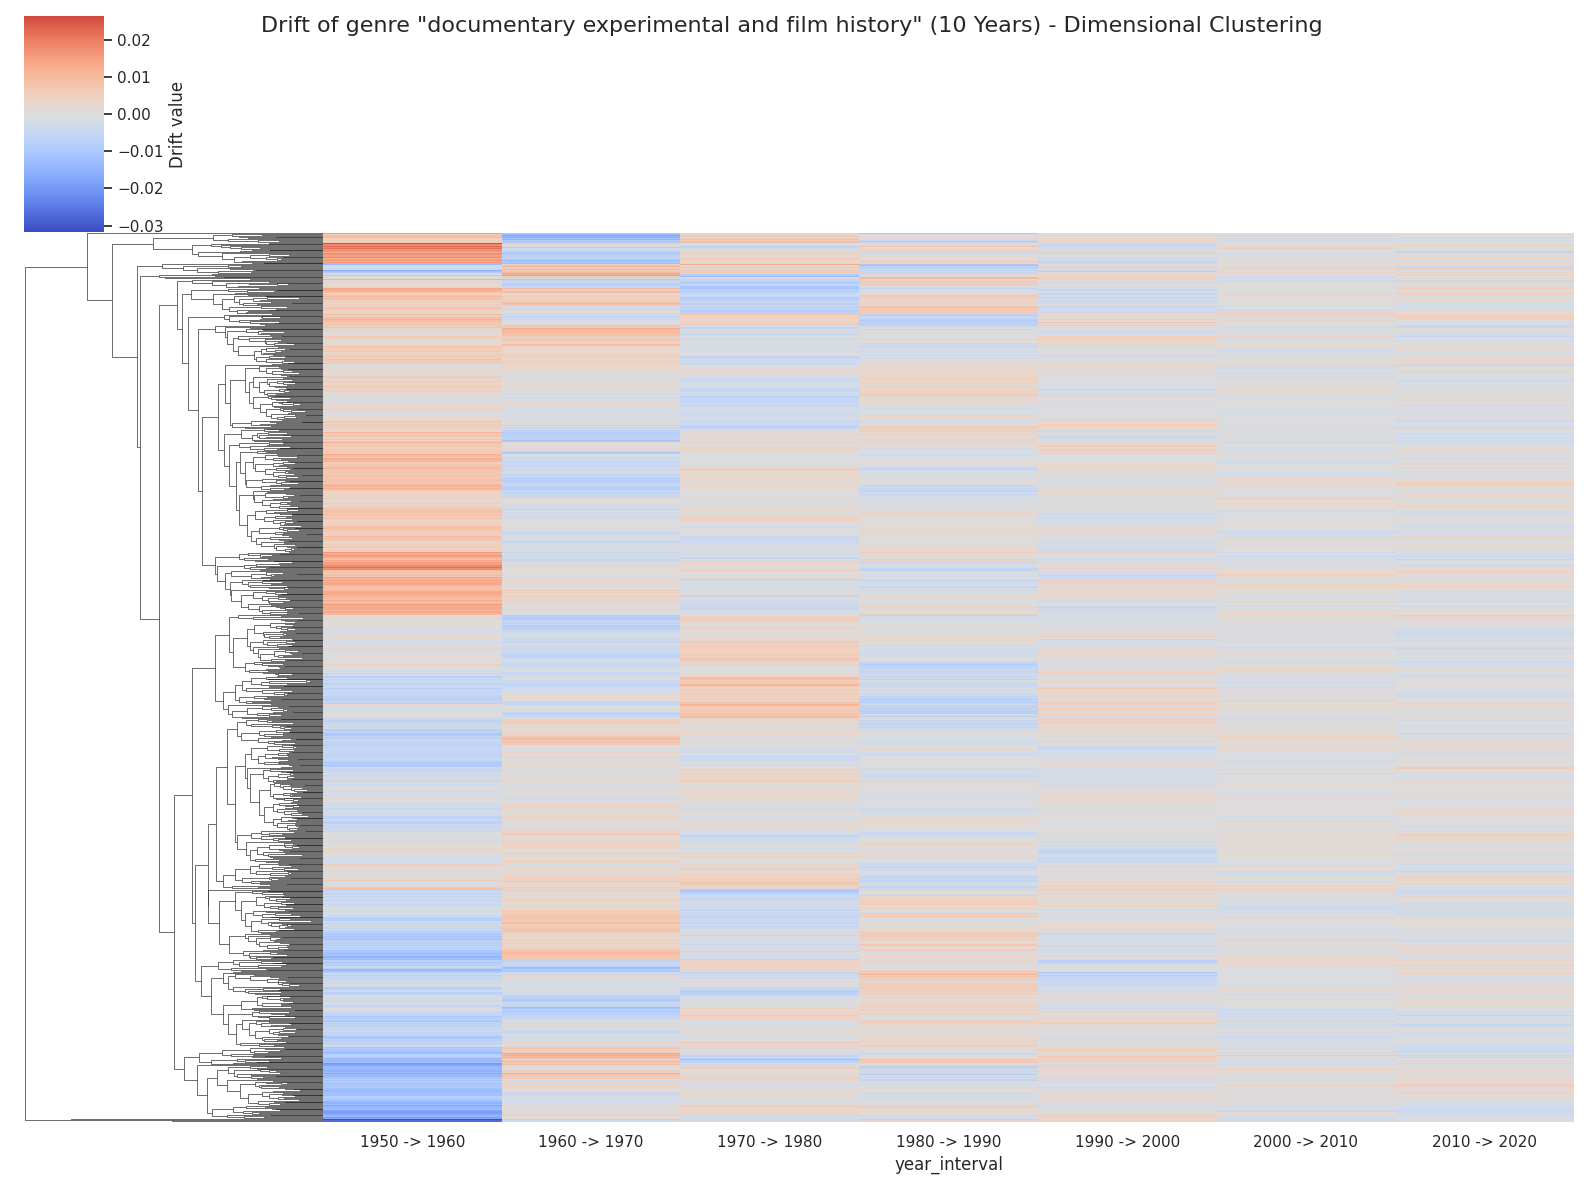

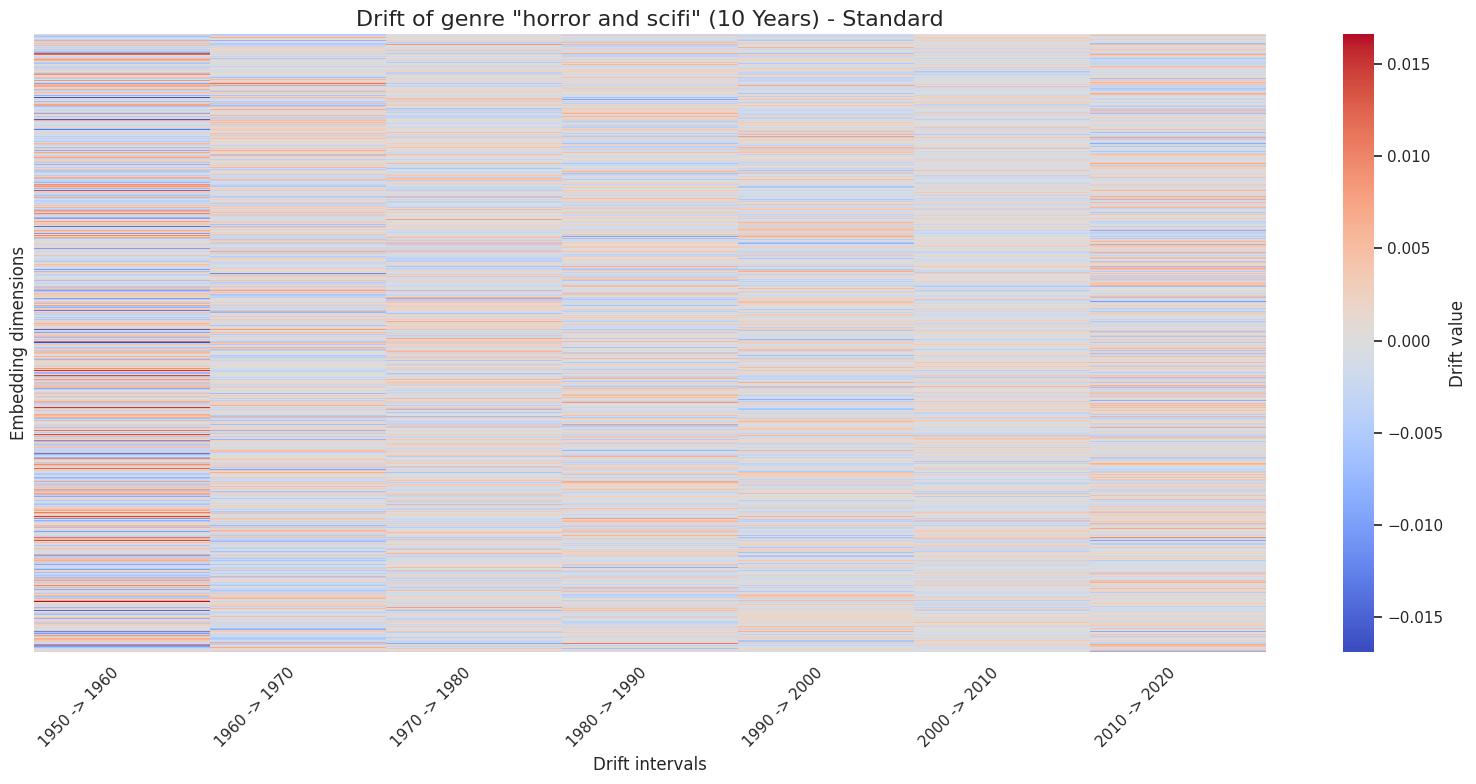

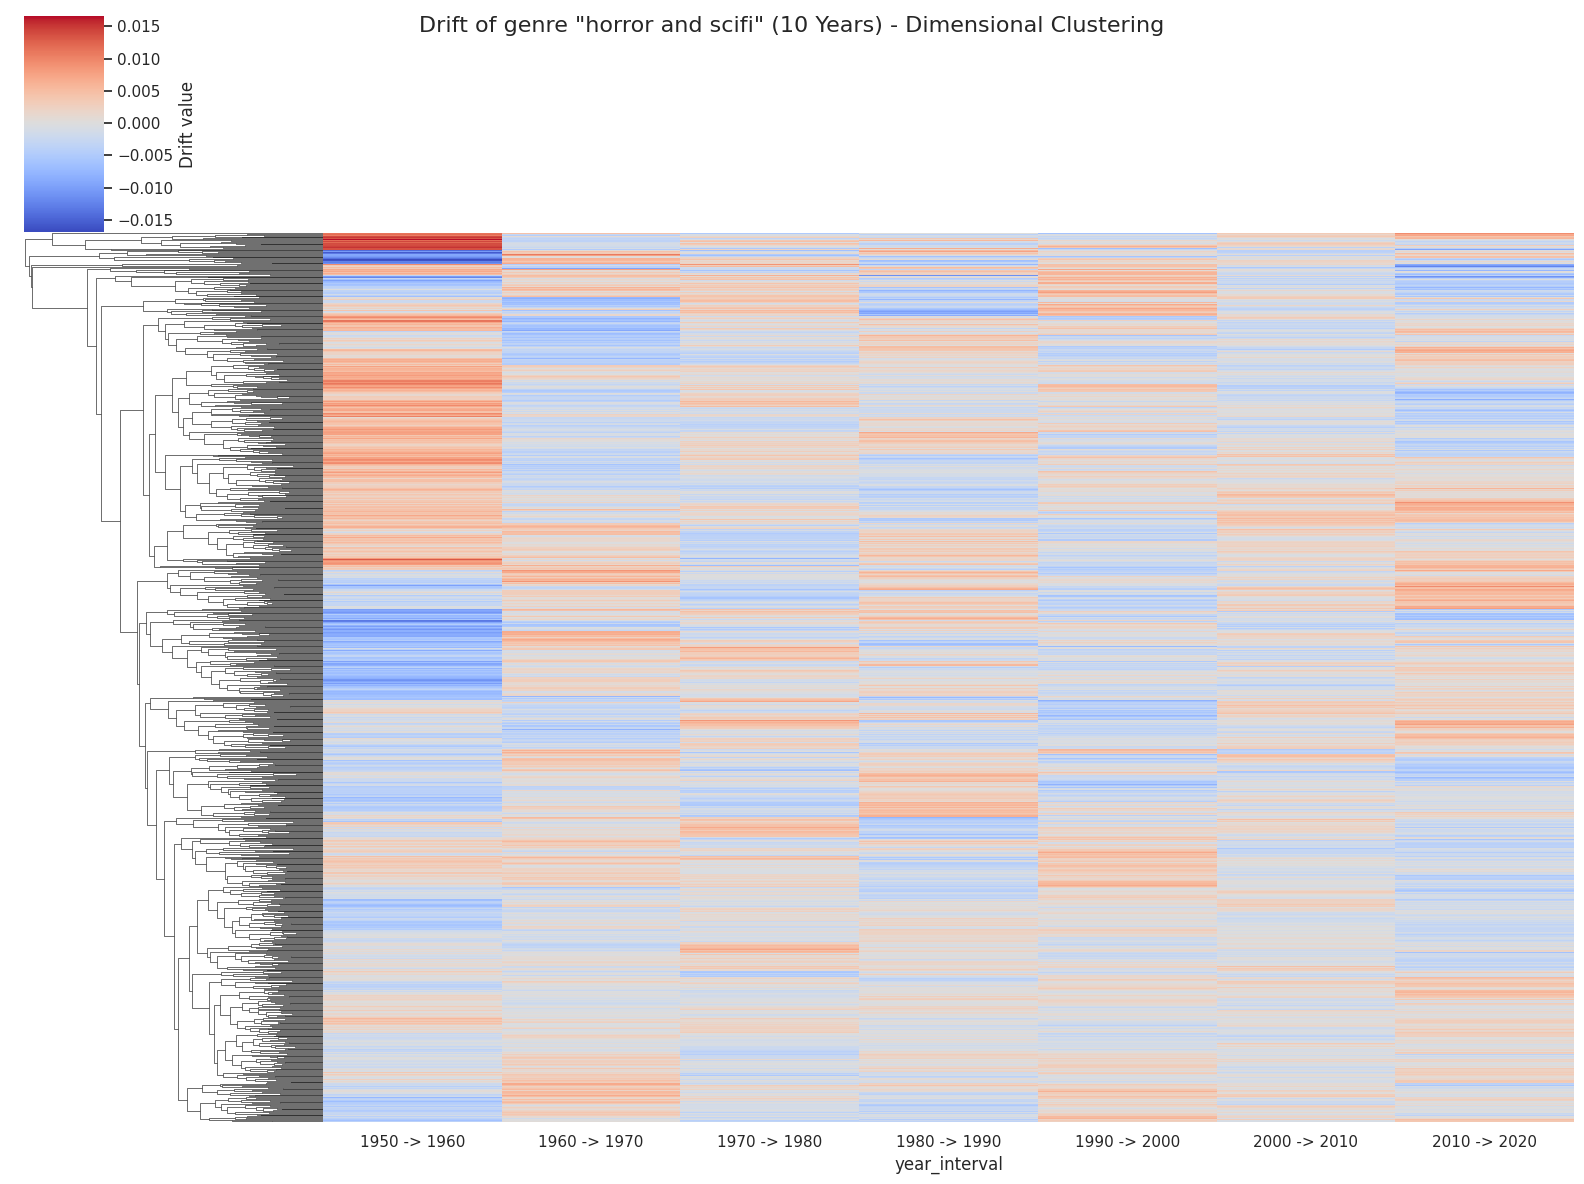

In [3]:
for genre in df_movies['new_genre'].unique():
    plot_data, bin_size = prepare_heatmap_data(drift_df, target_genre=genre, bin_size=10)

    plot_standard_heatmap(plot_data, target_genre=genre, bin_size=bin_size)
    plot_clustermap(plot_data, target_genre=genre, bin_size=bin_size)


# Inter-genre distance analysis

First plot visualizes the semantic separation between every pair of genres over time. For a single target genre (e.g., Comedy), it calculates the Cosine Distance between its average embedding vector and the vector of every other genre (e.g., Action, Drama) for each year or time bin. This results in many lines on the chart, where each line shows the changing distance between the target genre and one other genre. The plot shows if the meaning of two specific genres is getting closer (converging) or further apart (diverging) over time.

Second plot visualizes how unique or isolated each genre is compared to the rest of the film landscape over time. For a single target genre (e.g., Comedy), it first computes the average embedding vector of all the other genres combined. It then calculates the Cosine Distance between the target genre's vector and this single "mean of all others" vector for each time period. The plot shows one line per genre: if the line trends down, the genre is becoming more typical of the overall average; if it trends up, the genre is becoming more distinct.


In [4]:
target_genres = drift_df['new_genre'].unique()
convergence_df = calculate_genre_convergence(drift_df, bin_size=5, target_genres=target_genres)

print(convergence_df.head(10))

horror_action_trend = convergence_df[(convergence_df['Genre_A'] == 'Horror') & (convergence_df['Genre_B'] == 'Action')]
print(horror_action_trend)

  Genre_A                                    Genre_B  Year_Interval_Start  \
0  comedy  documentary experimental and film history                 1950   
1  comedy  documentary experimental and film history                 1955   
2  comedy  documentary experimental and film history                 1960   
3  comedy  documentary experimental and film history                 1965   
4  comedy  documentary experimental and film history                 1970   
5  comedy  documentary experimental and film history                 1975   
6  comedy  documentary experimental and film history                 1980   
7  comedy  documentary experimental and film history                 1985   
8  comedy  documentary experimental and film history                 1990   
9  comedy  documentary experimental and film history                 1995   

   Cosine_Distance  
0         0.148926  
1         0.165527  
2         0.126465  
3         0.117676  
4         0.115234  
5         0.109375  
6    

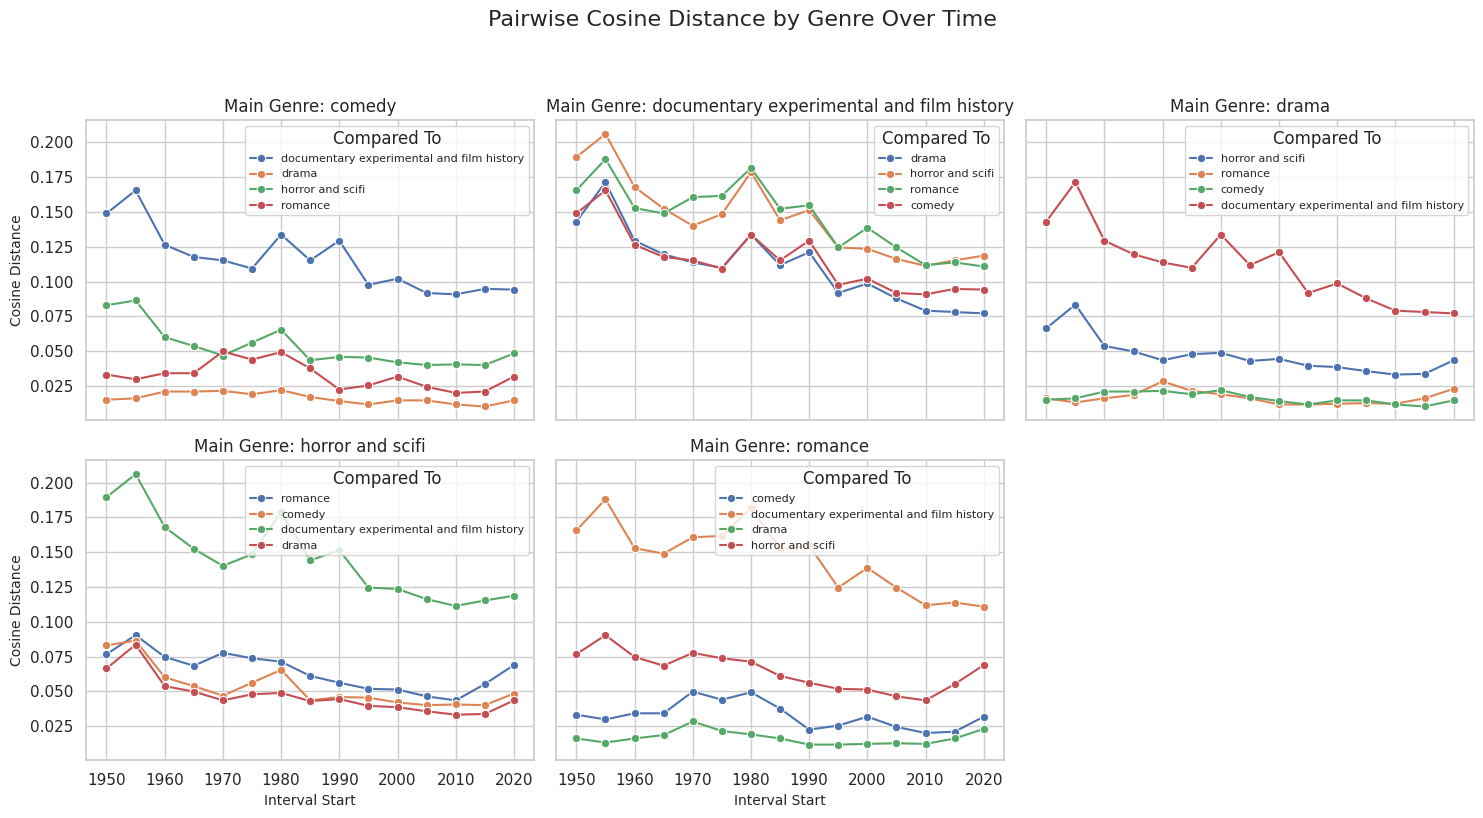

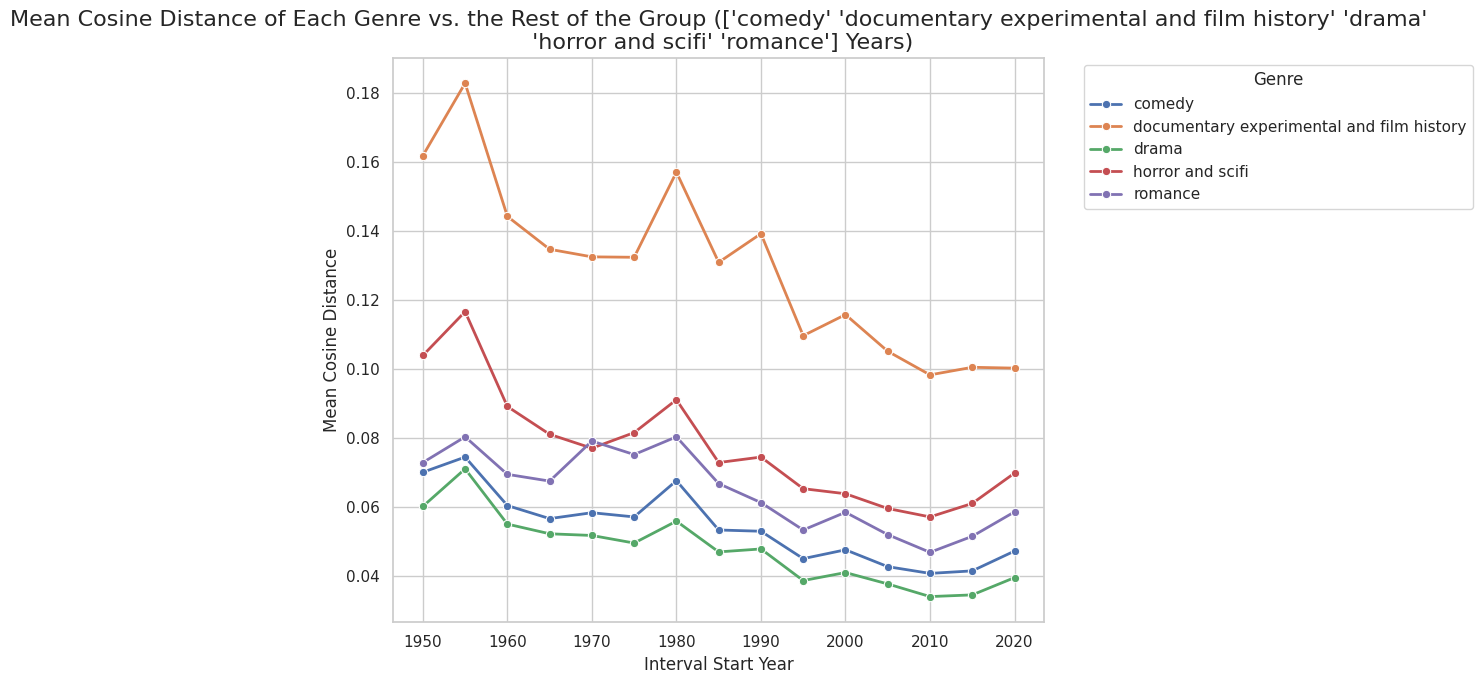

In [5]:
plot_pairwise_convergence(convergence_df, target_genres)
plot_mean_convergence(convergence_df, target_genres)